In [794]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np

In [795]:
subprocess.run(["g++", "-o", "bar", "bar.cpp", "-lm"])
subprocess.run(["./bar"])

Simulation complete. Data written to joint_positions.csv


CompletedProcess(args=['./bar'], returncode=0)

In [796]:
df = pd.read_csv("bar_data/joint_positions.csv")
df.head()

,time,x0,y0,x1,y1,x2,y2,distance
0,0.0,-1.9430,2.5328,2.7240,6.7534,3.6432,2.4216,4.3746
1,0.1,-2.1060,2.3990,2.1853,7.0012,2.9688,2.6428,3.9747
2,0.2,-2.2597,2.2548,1.6247,7.2052,2.2717,2.8244,3.6246
3,0.3,-2.4036,2.1007,1.0458,7.3635,1.5558,2.9646,3.3480
4,0.4,-2.5370,1.9375,0.4524,7.4745,0.8248,3.0619,3.1710


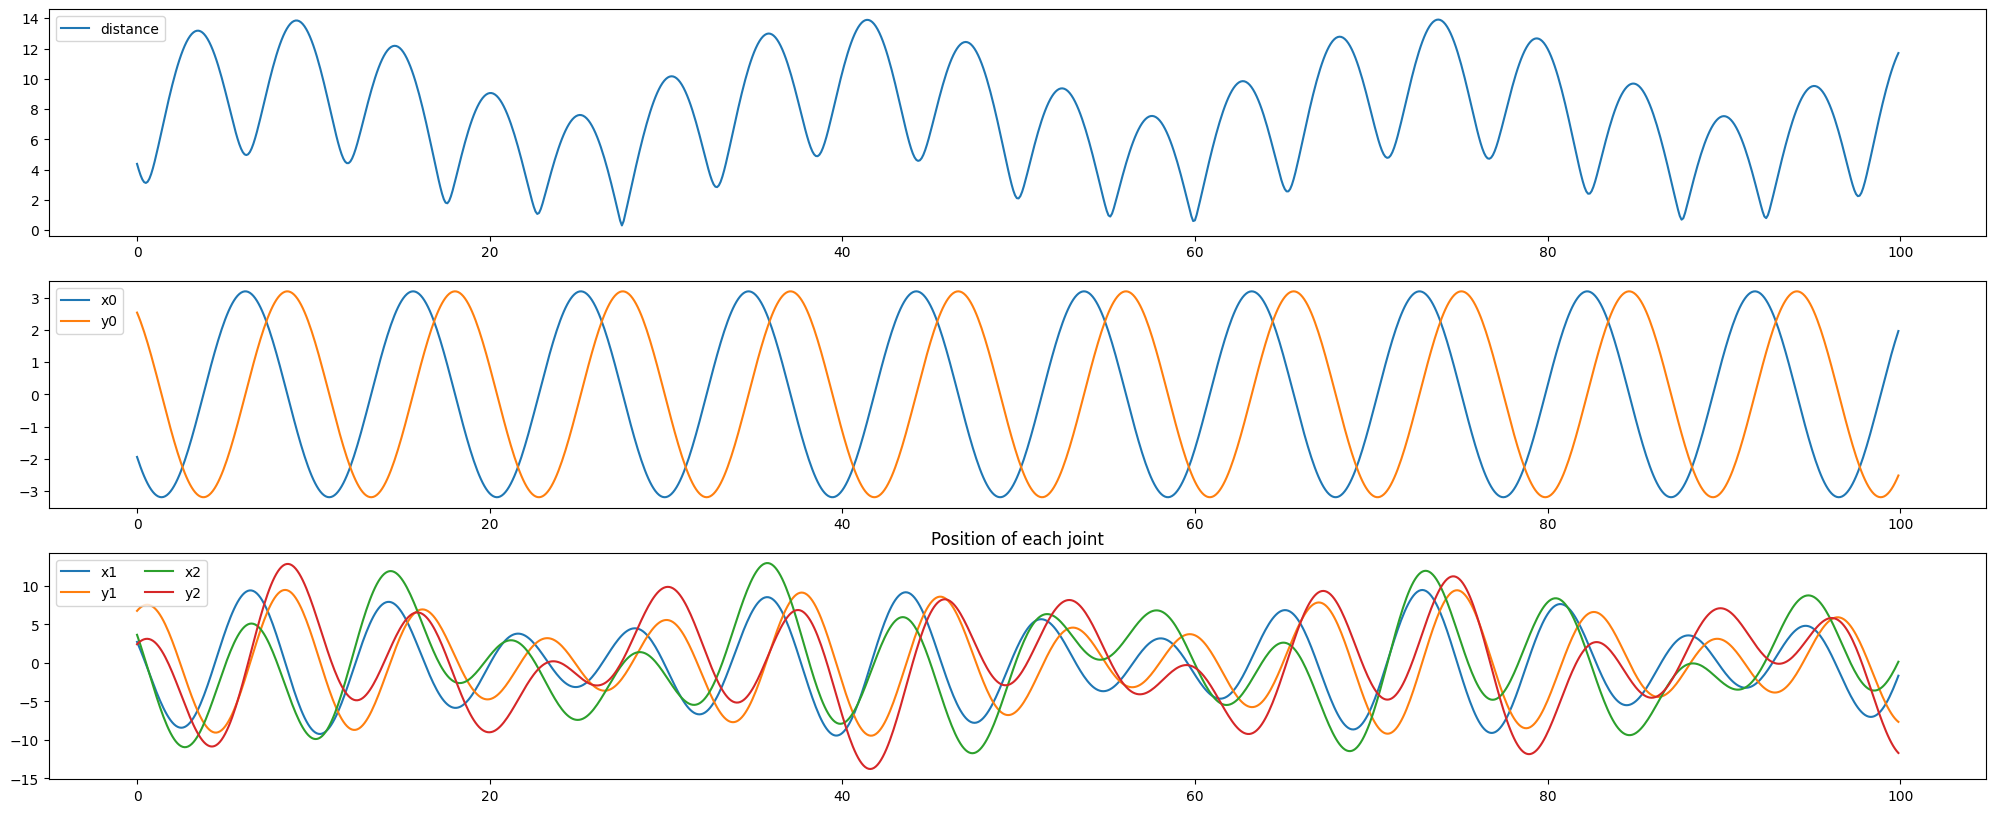

In [797]:
fig, ax = plt.subplots(figsize=(25, 10), ncols=1, nrows=3)
ax1, ax2, ax3 = ax
ax1.plot(df["time"], df["distance"], label = "distance")
ax1.legend(loc = "upper left")
headers = df.columns.tolist()
reference = headers[0]
others = headers[1:-1]
ax2.plot(df[reference], df[others[0]], label = others[0])
ax2.plot(df[reference], df[others[1]], label = others[1])
ax2.legend(loc = "upper left")
for header in others[2:]:
    ax3.plot(df[reference], df[header], label=header)
ax3.legend(loc = "upper left", ncol = int(len(headers[1:-1])/3))
plt.title("Position of each joint")
plt.show()

In [798]:
distance = pd.DataFrame()
distance["time"] = df["time"]
# Group x and y together as distance sqrt(x^2 + y^2)

for i in range(int(len(headers[1:-1])/2)):
    data_x = df["x"+str(i)]
    data_y = df["y"+str(i)]
    distance_data = np.sqrt(data_x**2 + data_y**2)
    new_header = "distance"+str(i)
    distance[new_header] = distance_data

distance.head()

,time,distance0,distance1,distance2
0,0.0,3.192229,7.282073,4.374592
1,0.1,3.192246,7.334326,3.974691
2,0.2,3.192235,7.386106,3.624618
3,0.3,3.192215,7.437394,3.348039
4,0.4,3.192221,7.488178,3.171045


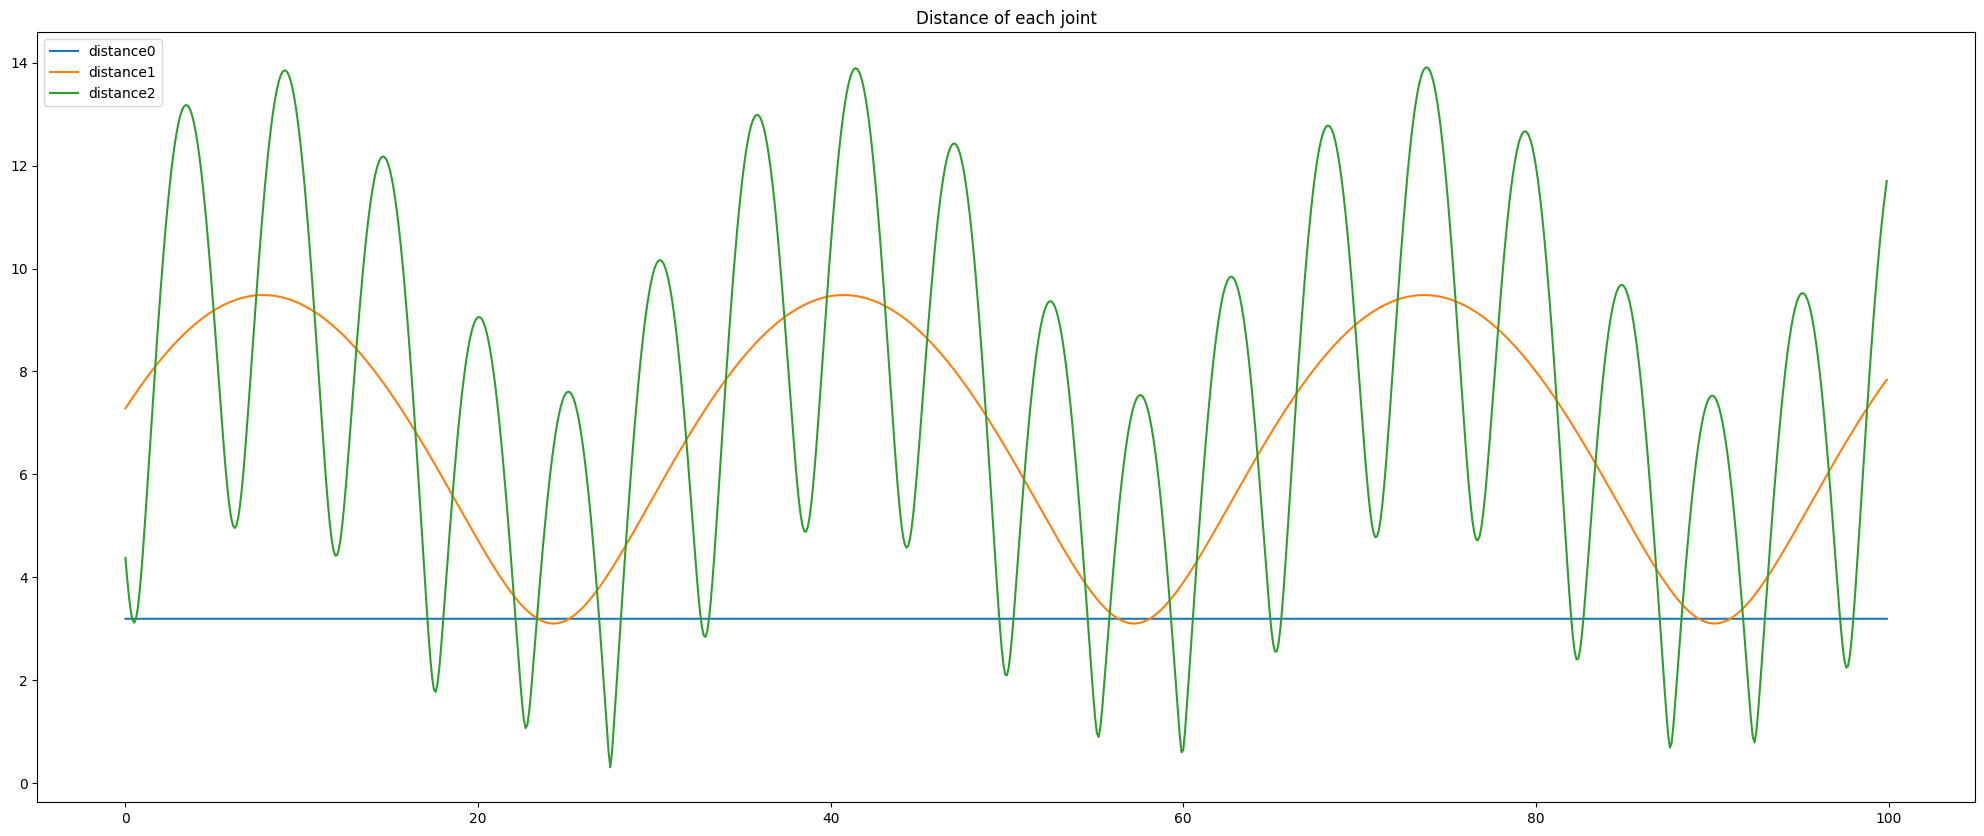

In [799]:
plt.figure(figsize=(25, 10))
headers = distance.columns.tolist()
reference = headers[0]
others = headers[1:]

for header in others:
    plt.plot(distance[reference], distance[header], label=header)
plt.legend(loc = "upper left")
plt.title("Distance of each joint")
plt.show()

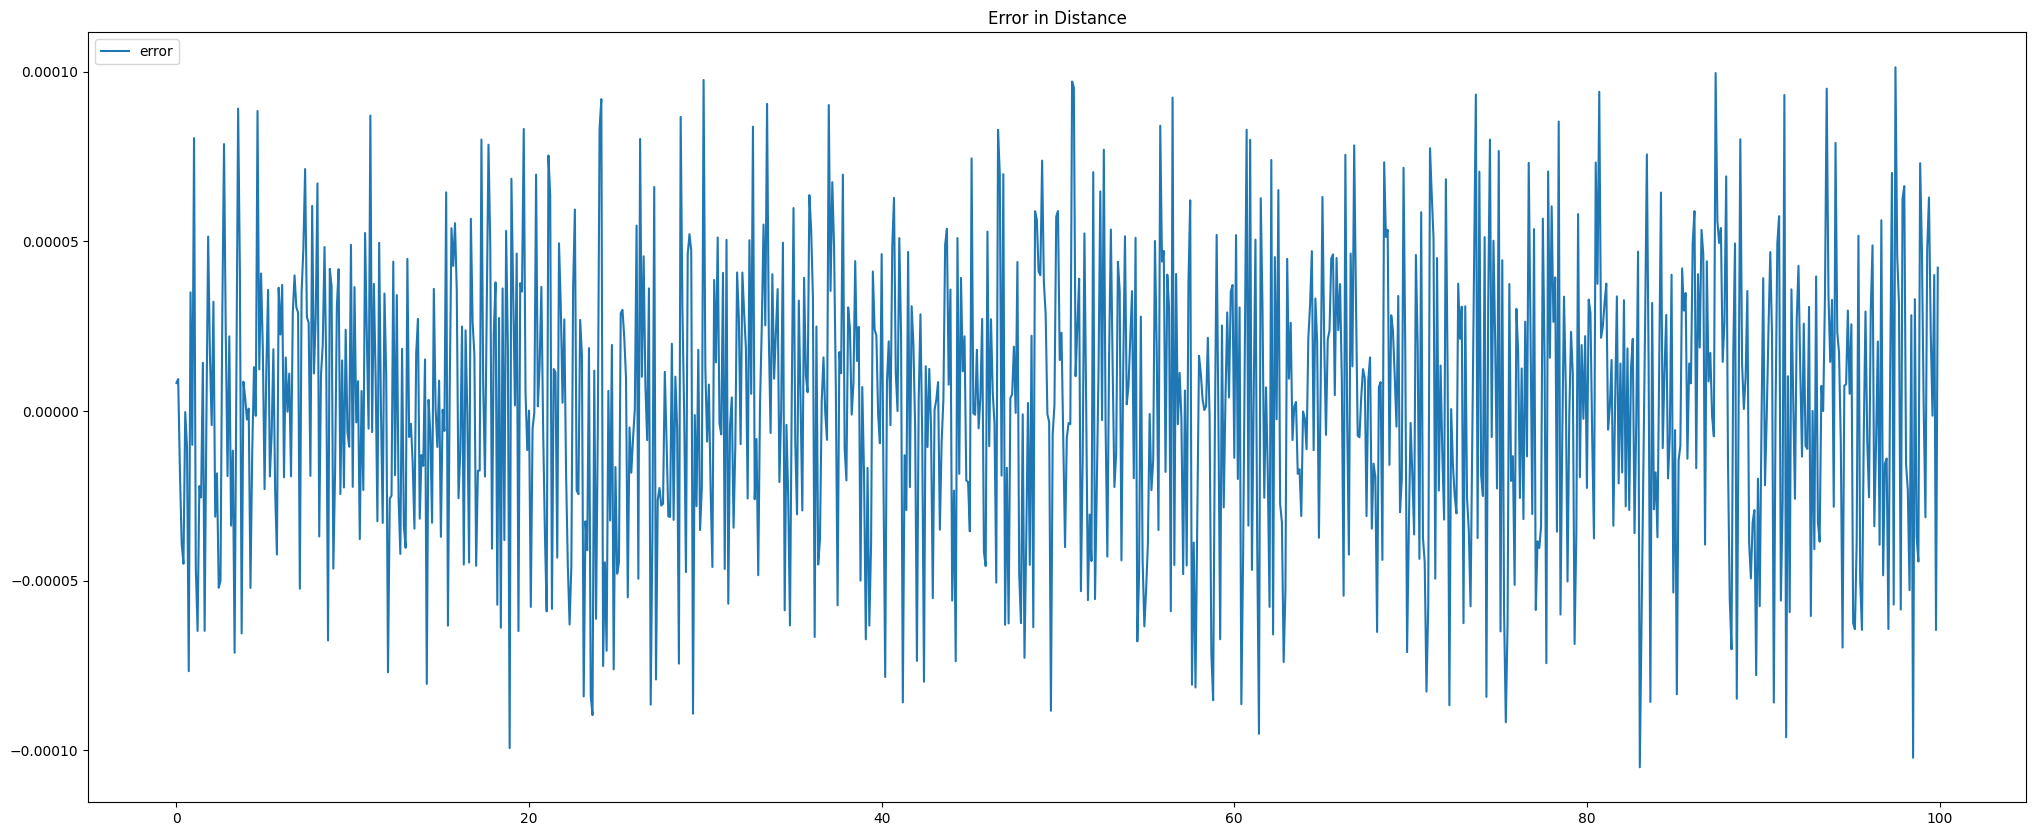

In [800]:
plt.figure(figsize=(25, 10))
plt.plot(df["time"], df.iloc[:, -1] - distance.iloc[:, -1], label="error")
plt.legend(loc = "upper left")
plt.title("Error in Distance")
plt.show()

In [801]:
num_joints = int((len(df.columns) - 2) / 2)  # subtract 'time' and 'distance' column

D1 = pd.DataFrame()
D1["time"] = df["time"]

D1["D1_0"] = np.sqrt(df["x0"]**2 + df["y0"]**2)

for i in range(num_joints - 1):
    dx = df[f"x{i+1}"] - df[f"x{i}"]
    dy = df[f"y{i+1}"] - df[f"y{i}"]
    bar = np.sqrt(dx**2 + dy**2)
    D1[f"D1_{i+1}"] = bar

D1.head()

,time,D1_0,D1_1,D1_2
0,0.0,3.192229,6.292404,4.428252
1,0.1,3.192246,6.292496,4.428264
2,0.2,3.192235,6.292458,4.428320
3,0.3,3.192215,6.292490,4.428366
4,0.4,3.192221,6.292446,4.428286


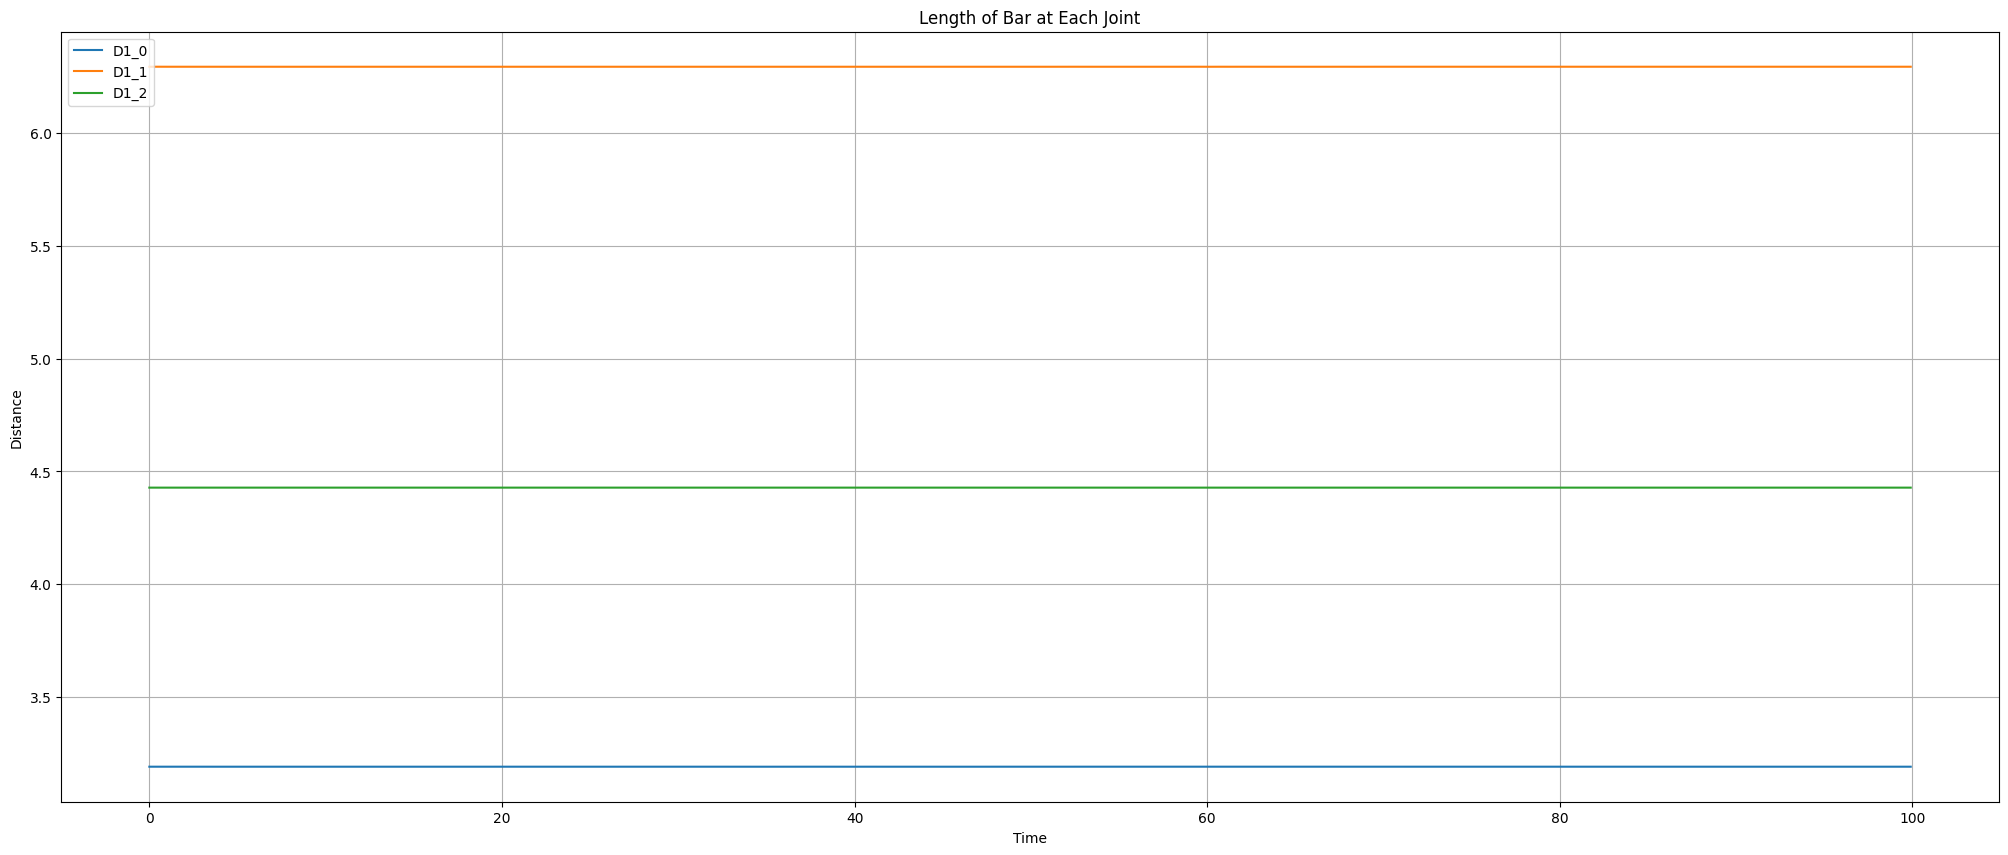

In [ ]:
# Plotting
plt.figure(figsize=(25, 10))
for col in D1.columns[1:]:
    plt.plot(D1["time"], D1[col], label=col)

plt.title("Length of Bar at Each Joint")
plt.xlabel("Time")
plt.ylabel("Length")
plt.legend(loc = "upper left")
plt.grid(True)
plt.show()

In [803]:
average_length_bar = []
for col in D1.columns[1:]:
    average_length_bar.append(float(D1[col].mean()))

del D1
print("Average length of bar:")
for index, value in enumerate(average_length_bar):
    print(f"Joint {index}: {value}")

Average length of bar:
Joint 0: 3.1922211192411707
Joint 1: 6.292440703380072
Joint 2: 4.428311962405085


In [804]:
D2 = pd.DataFrame()
D2["time"] = df["time"]

def angle_cosine_rule(distance: np.ndarray, side1: float, side2: float) -> np.ndarray:
    # Create output array of same shape filled with nan
    result = np.full_like(distance, np.nan)

    # Apply cosine rule only where valid
    result = (distance**2 - side1**2 - side2**2) / (-2 * side1 * side2)
    return np.arccos(np.clip(result, -1.0, 1.0))

D2["angle0"] = np.arctan(df["y0"] / df["x0"])
D2_0 = np.sqrt(df["x1"]**2 + df["y1"]**2)
D2["angle1"] = angle_cosine_rule(D2_0, average_length_bar[0], average_length_bar[1])
del D2_0

for i in range(num_joints - 2):
    dx = df[f"x{i+2}"] - df[f"x{i}"]
    dy = df[f"y{i+2}"] - df[f"y{i}"]
    distance = np.sqrt(dx**2 + dy**2)
    D2[f"angle{i+2}"] = angle_cosine_rule(distance, average_length_bar[i], average_length_bar[i+1])

D2.head()

,time,angle0,angle1,angle2
0,0.0,-0.916419,1.651621,1.090356
1,0.1,-0.850346,1.670711,0.931402
2,0.2,-0.784313,1.689798,0.766923
3,0.3,-0.718252,1.708881,0.590897
4,0.4,-0.652210,1.727956,0.385916


In [805]:
# Compare angles with real data
angle_data = pd.read_csv("bar_data/joint_angles.csv")
angle_data.head()

,time,angle0,angle1,angle2,distance
0,0.0,2.2252,0.7352,-1.3617,4.3746
1,0.1,2.2912,0.8203,-1.3929,3.9747
2,0.2,2.3573,0.9055,-1.4242,3.6246
3,0.3,2.4233,0.9906,-1.4554,3.3480
4,0.4,2.4894,1.0757,-1.4866,3.1710


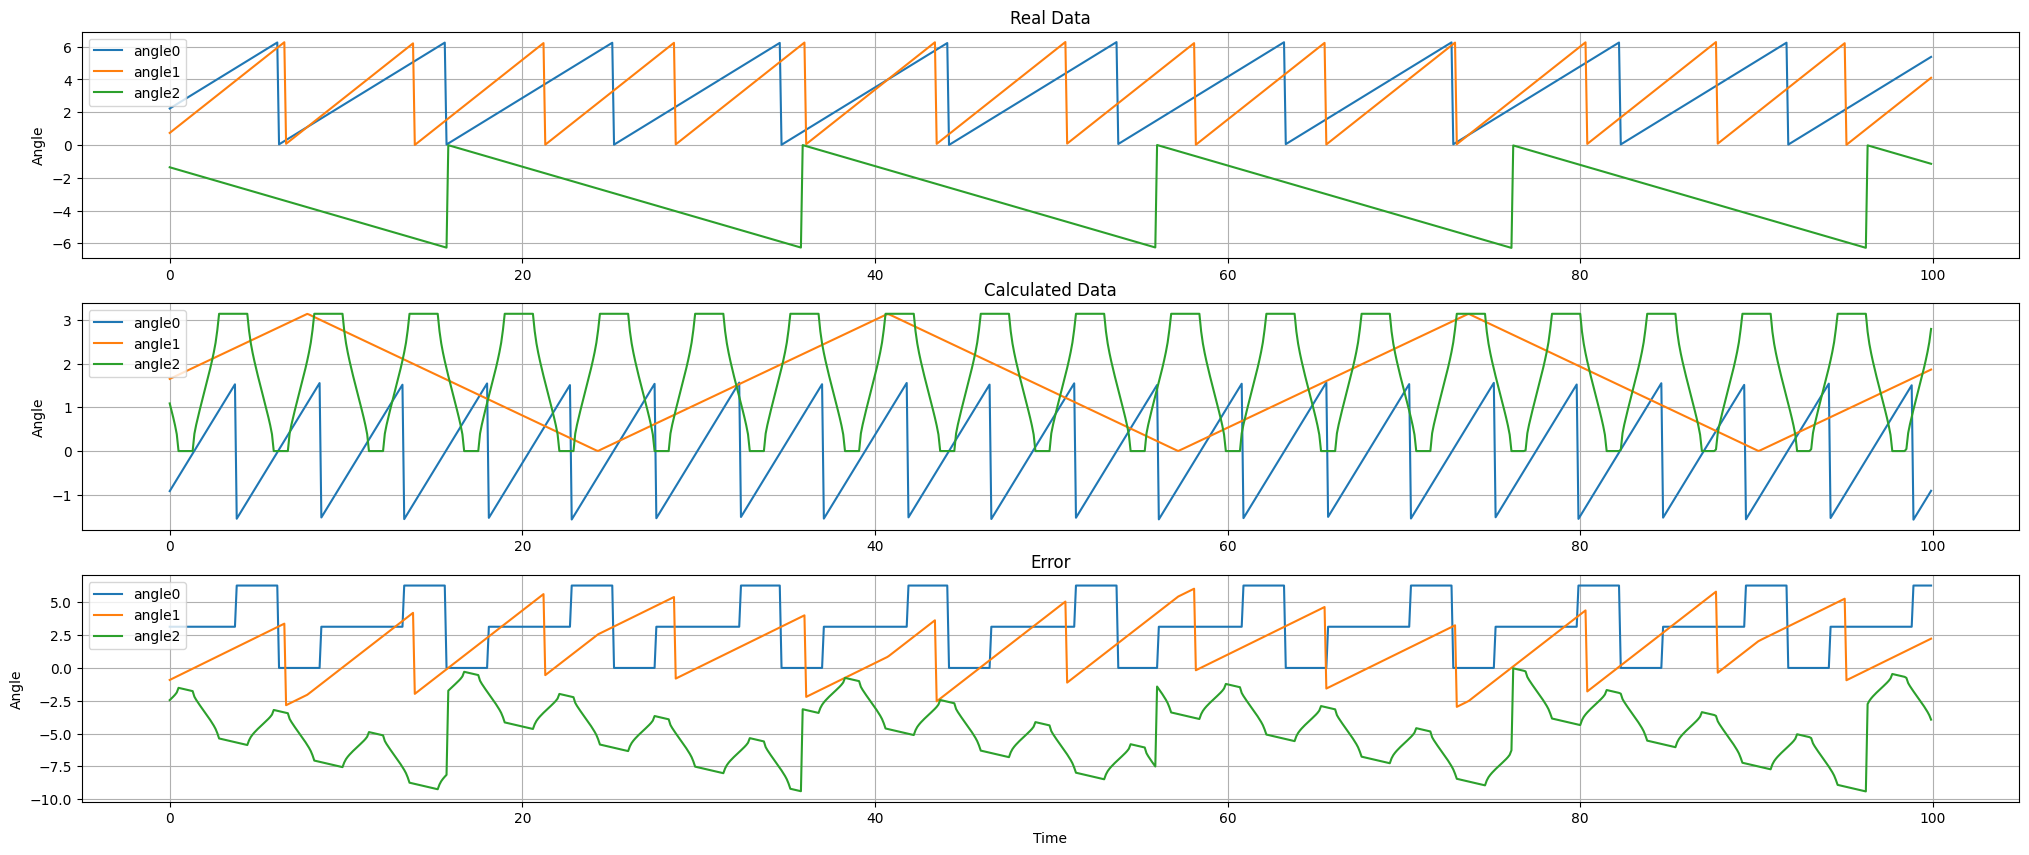

In [806]:
fig, ax = plt.subplots(figsize=(25, 10), ncols=1, nrows=3)
ax1, ax2, ax3 = ax

for i in range(num_joints):
    ax1.plot(angle_data["time"], angle_data[f"angle{i}"], label = f"angle{i}")
    ax1.legend(loc = "upper left")
    ax2.plot(D2["time"], D2[f"angle{i}"], label = f"angle{i}")
    ax2.legend(loc = "upper left")
    ax3.plot(angle_data["time"], angle_data[f"angle{i}"] - D2[f"angle{i}"], label = f"angle{i}")
    ax3.legend(loc = "upper left")

ax1.set_title("Real Data")
ax1.set_ylabel("Angle")
ax1.grid(True)

ax2.set_title("Calculated Data")
ax2.set_ylabel("Angle")
ax2.grid(True)

ax3.set_title("Error")
ax3.set_ylabel("Angle")
ax3.grid(True)

plt.xlabel("Time")
plt.show()

In [807]:
# Rebuild the model
reconstruct = pd.DataFrame()

for row in D2.itertuples():
    x_pos = 0.0
    y_pos = 0.0

    for i in range(len(average_length_bar)):
        x_pos += average_length_bar[i] * np.cos(row[i])
        y_pos += average_length_bar[i] * np.sin(row[i])

    reconstruct.loc[row.Index, "time"] = row.time
    reconstruct.loc[row.Index, "x"] = x_pos
    reconstruct.loc[row.Index, "y"] = y_pos
    reconstruct.loc[row.Index, "distance"] = np.sqrt(x_pos**2 + y_pos**2)

reconstruct["x error"] = np.subtract(reconstruct["x"], df[f"x{len(average_length_bar)-1}"])
reconstruct["y error"] = np.subtract(reconstruct["y"], df[f"y{len(average_length_bar)-1}"])
reconstruct["error distance"] = np.subtract(reconstruct["distance"], df["distance"])

reconstruct.head()

,time,x,y,distance,x error,y error,error distance
0,0.0,12.180023,-3.513542,12.676669,8.536823,-5.935142,8.302069
1,0.1,10.907231,-0.013556,10.907239,7.938431,-2.656356,6.932539
2,0.2,7.973264,1.024905,8.038866,5.701564,-1.799495,4.414266
3,0.3,6.185451,-0.604109,6.214882,4.629651,-3.568709,2.866882
4,0.4,7.228523,-2.653227,7.700075,6.403723,-5.715127,4.529075


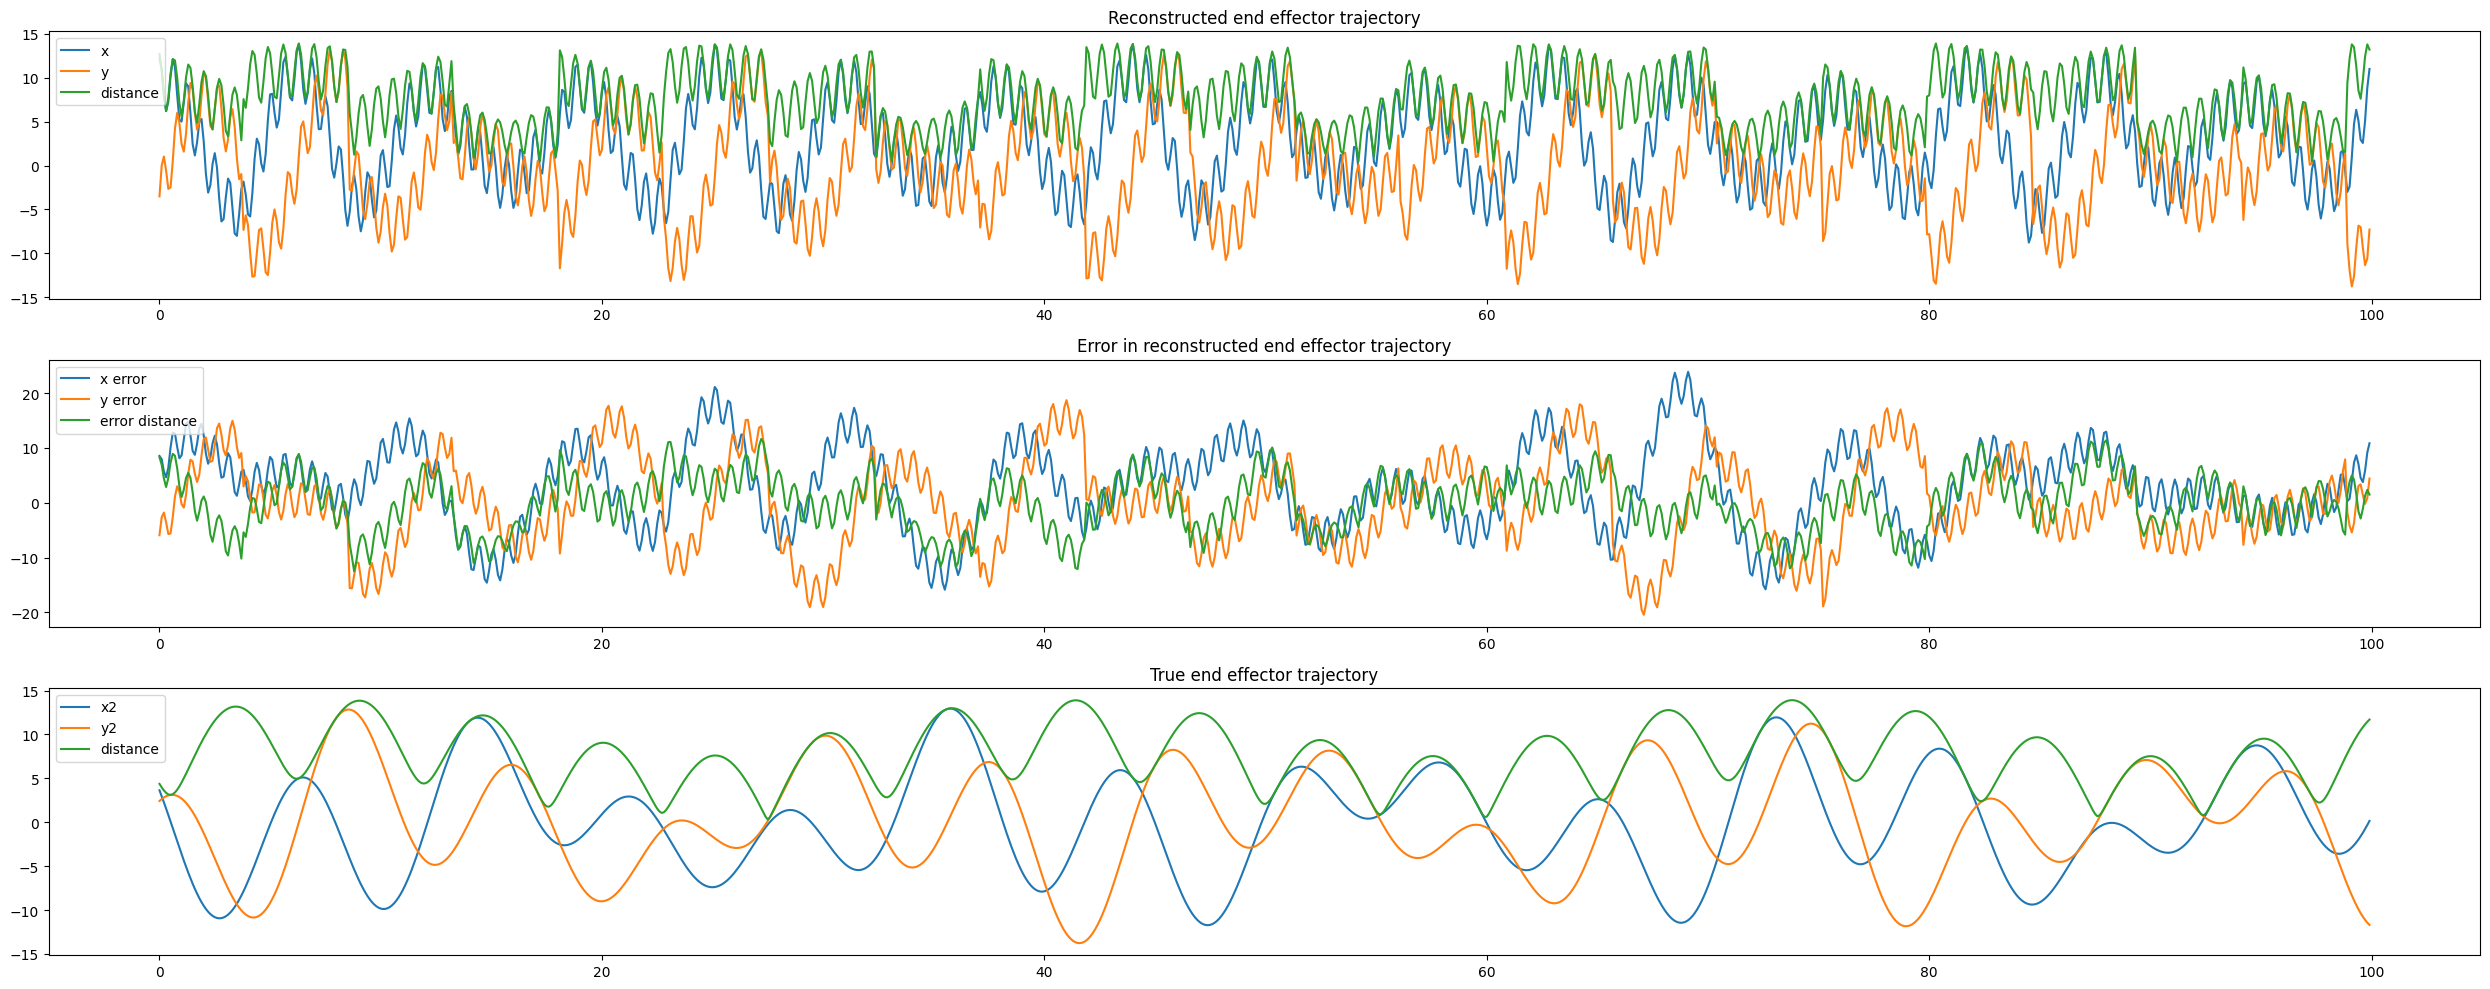

In [808]:
fig, ax = plt.subplots(figsize=(25, 10), ncols=1, nrows=3)
ax1, ax2, ax3 = ax

ax3.plot(df["time"], df[f"x{len(average_length_bar)-1}"], label = f"x{len(average_length_bar)-1}")
ax3.plot(df["time"], df[f"y{len(average_length_bar)-1}"], label = f"y{len(average_length_bar)-1}")
ax3.plot(df["time"], df["distance"], label = "distance")
ax3.legend(loc = "upper left")
ax3.set_title("True end effector trajectory")

others = ["x", "y", "distance"]
for header in others:
    ax1.plot(reconstruct["time"], reconstruct[header], label = header)
ax1.legend(loc = "upper left")
ax1.set_title("Reconstructed end effector trajectory")

error_list = ["x error", "y error", "error distance"]
for header in error_list:
    ax2.plot(reconstruct["time"], reconstruct[header], label = header)
ax2.legend(loc = "upper left")
ax2.set_title("Error in reconstructed end effector trajectory")

fig.tight_layout()
plt.show()